### Python Assignment 1

In this assignment you will get familiar with analyzing drifter data. The drifters that we will use were released during the Australasian Antarctic Expedition in December 2013, a project designed to characterize eddy dispersion and diffusivity along an Antarctic Circumpolar Current front. For more information you may take a look at [this scientific article](https://doi.org/10.1002/2015JC010972). An animation of the drifters can be found on http://oceanparcels.org/aaemap.

We assume that you have completed all steps in the *Getting python-ready for Dynamical Oceanography* document and have a new environment called *dyoc*. Now check that you are in the right environment by running the following cell:

In [1]:
!conda env list

# conda environments:
#
base                     /Users/jasperdejong/opt/anaconda3
dyoc                  *  /Users/jasperdejong/opt/anaconda3/envs/dyoc
py311                    /Users/jasperdejong/opt/anaconda3/envs/py311



You should see an asterisk next to your *dyoc* environment. If this is not the case, you may stop the *Jupyter lab* instance using `ctrl + c` in your terminal (Mac) or Anaconda prompt (Windows). Then type `conda activate dyoc` to activate the environment and `jupyter lab` to start *Jupyter lab* again.  

Now import the following packages:

In [2]:
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import matplotlib.cm
import cartopy
import cmocean
import geopy.distance

Then download the file `aaedrifters.json` from http://oceanparcels.org/aaemap by clicking on the right-most of the four icons on the bottom-left. Put that file it in the same directory or folder as this notebook and load the data using the code below

In [3]:
def reshape_jsonarrays(item):
    time = np.array([d[0] for d in item[1]], dtype='datetime64')
    lat = np.array([d[1] for d in item[1]], dtype='float')
    lon = np.array([d[2] for d in item[1]], dtype='float')
    return {'name':item[0], 'time':time, 'lat':lat, 'lon':lon}

with open("aaedrifters.json") as fp:
    jsondata = json.load(fp)

drifters = [reshape_jsonarrays(item) for item in jsondata.items()]

Have a quick look of the content of the new `drifter` list by running the following cell:

In [4]:
drifters

[{'name': '130258',
  'time': array(['2013-12-11T17:00:00', '2013-12-11T18:00:00',
         '2013-12-11T18:59:59', ..., '2014-07-31T20:00:00',
         '2014-07-31T21:00:00', '2014-07-31T23:00:00'],
        dtype='datetime64[s]'),
  'lat': array([-56.472, -56.471, -56.471, ..., -52.507, -52.508, -52.509]),
  'lon': array([156.648, 156.658, 156.667, ..., 212.221, 212.229, 212.242])},
 {'name': '130259',
  'time': array(['2013-12-11T17:00:00', '2013-12-11T18:00:00',
         '2013-12-11T18:59:59', ..., '2014-07-31T21:00:00',
         '2014-07-31T21:59:59', '2014-07-31T23:00:00'],
        dtype='datetime64[s]'),
  'lat': array([-56.472, -56.471, -56.472, ..., -49.301, -49.286, -49.271]),
  'lon': array([156.648, 156.658, 156.667, ..., 198.133, 198.145, 198.156])},
 {'name': '130260',
  'time': array(['2013-12-12T06:59:59', '2013-12-12T08:00:00',
         '2013-12-12T09:00:00', ..., '2014-07-31T21:00:00',
         '2014-07-31T21:59:59', '2014-07-31T23:00:00'],
        dtype='datetime64[s]'

The drifter pairs were deployed on a straight line along the cruise track between approximately (56.0°S, 157.2°E) and (58.8°S, 153.5°E) over a 25 h period starting on 11 December 2013.  

Make a simple plot of all trajectories in `drifters` using `plt.plot`, both for the complete duration of the experiment and the first ten days after release.

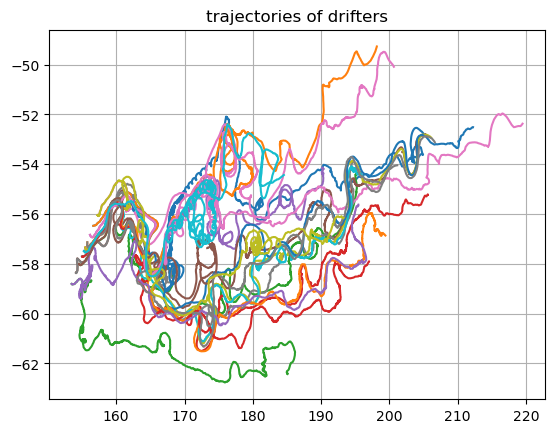

In [5]:
# ANSWER
for data in drifters:
    plt.plot(data['lon'], data['lat'])
plt.title(f"trajectories of drifters")
plt.grid()

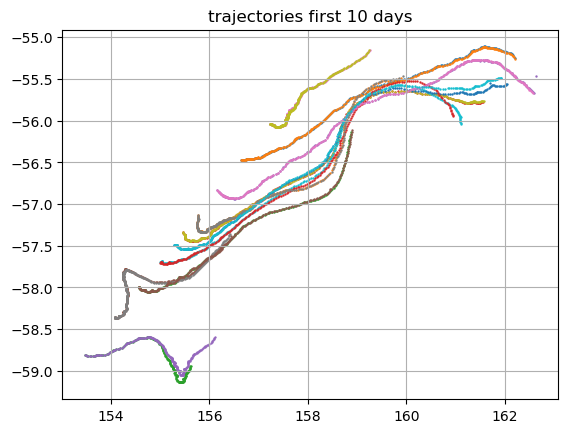

In [6]:
# ANSWER
ndays = 10 # number of days from start to plot
for data in drifters:
    days = (data['time']-data['time'][0]).astype('timedelta64[D]').astype('int')
    imax = list(days).index(ndays)
    plt.scatter(data['lon'][:imax], data['lat'][:imax],s=0.5)
plt.title(f'trajectories first {ndays} days')
plt.grid()

To get a better view on the trajectories, it might be nice to show the continents as well. For this we use the `cartopy` package. Now run the following cell and see the resulting map.

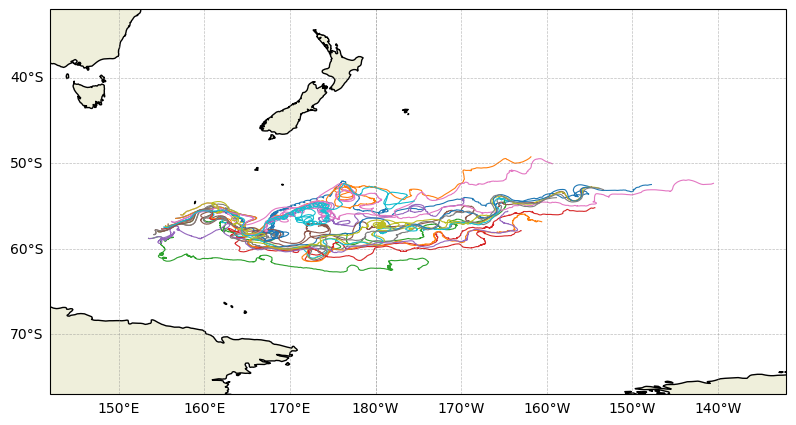

In [7]:
# We use the Platecarree projection centered at 180 degrees longitude
# on Cartopy's website you can find other projections to play around with
projection = cartopy.crs.PlateCarree(central_longitude=180)

# whenever adding data having latitude-longitude coordinates, use PlateCarree() as coordinate reference system
data_crs = cartopy.crs.PlateCarree()

# initialisation of the figure
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1, projection=projection)

# plot coastlines and colour the land surfaces
ax.coastlines(resolution='50m')
ax.add_feature(cartopy.feature.LAND)

# plot trajectories
for d in drifters[:]:
    ax.plot(d['lon'], d['lat'], transform=data_crs, lw=0.8)

# plot grid lines and format the labels
# xlocs is needed because the locator does not work so well when crossing 180 degrees longitude
gl = ax.gridlines(crs=data_crs, draw_labels=['bottom','left'], linewidth=0.5,
              color='gray', alpha=0.5, linestyle='--', xlocs=range(-180,181,10))
gl.xformatter = cartopy.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cartopy.mpl.gridliner.LATITUDE_FORMATTER

# zoom out to see more land masses
ax.set_extent((142,228,-77,-32), crs=data_crs)

Complete the function `drifter_velocity` below that computes the zonal and meridional velocities of a drifter. The function takes an element of `drifters` as an argument and returns two arrays, `u` and `v`. The remaining code will plot your results for drifter 130263. Make sure the vectors are aligned with the trajectory.

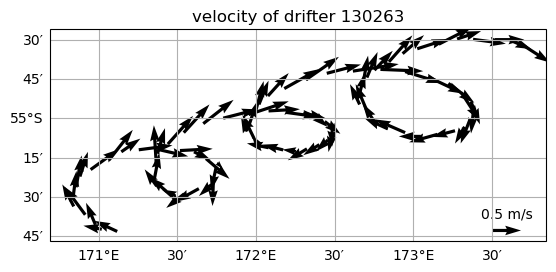

In [8]:
# ANSWER
def drifter_velocity(data):
    """compute zonal and meridional velocities of drifter
    data : dictionary containing arrays time, lat and lon
    u, v : array, zonal (meridional) velocity
    """
    Re = 6371000 # radius earth (m)
    time = (data['time'] - data['time'][0]).astype('timedelta64[s]')
    latr = np.deg2rad(data['lat'])
    lonr = np.deg2rad(data['lon'])
    u = Re*np.cos(latr)*np.gradient(lonr,time)
    v = Re*np.gradient(latr,time)
    return u,v

data = drifters[4]
u,v = drifter_velocity(data)

crs = cartopy.crs.PlateCarree()
ax = plt.axes(projection=crs)
pids = slice(1200,1550,4)
Q = ax.quiver(data['lon'][pids], data['lat'][pids], u[pids], v[pids], transform=crs, lw=0.5)
ax.quiverkey(Q, 0.92, 0.05, 0.5, label='0.5 m/s')
ax.set_title(f"velocity of drifter {data['name']}")
ax.gridlines(draw_labels=['left','bottom'], dms=True)
plt.show()

Now use the function `drifter_velocity` to create maps of zonal and meridional velocity for all drifters. Part of the code to plot the results has been given below.  
Hint: use `ax.scatter` to change colour along the trajectories.

In [9]:
# ANSWER
for d,data in enumerate(drifters):
    u,v = drifter_velocity(data)
    drifters[d]['u'] = u
    drifters[d]['v'] = v

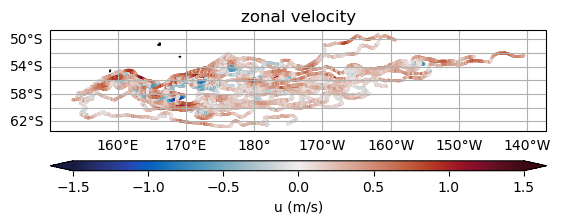

In [10]:
ax = plt.axes(projection=cartopy.crs.PlateCarree(central_longitude=180))

# ANSWER
for data in drifters:
    p = ax.scatter(data['lon'], data['lat'], c=data['u'], s=1, vmin=-1.5, vmax=1.5,
                   cmap=cmocean.cm.balance, transform=cartopy.crs.PlateCarree())
# ----
ax.set_title("zonal velocity")
ax.coastlines('50m')
ax.gridlines(draw_labels=['left','bottom'], transform=cartopy.crs.PlateCarree(), xlocs=range(-180,180,10))
ax.figure.colorbar(p, orientation='horizontal', extend='both', label="u (m/s)", aspect=50, pad=0.08)

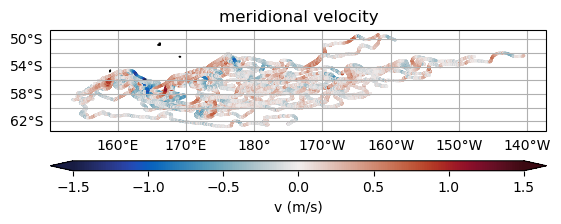

In [11]:
ax = plt.axes(projection=cartopy.crs.PlateCarree(central_longitude=180))

# ANSWER
for data in drifters:
    p = ax.scatter(data['lon'], data['lat'], c=data['v'], s=1, vmin=-1.5, vmax=1.5,
                   cmap=cmocean.cm.balance, transform=cartopy.crs.PlateCarree())
# ----
ax.set_title("meridional velocity")
ax.coastlines('50m')
ax.gridlines(draw_labels=['left','bottom'], transform=cartopy.crs.PlateCarree(), xlocs=range(-180,180,10))
ax.figure.colorbar(p, orientation='horizontal', extend='both', label="v (m/s)", aspect=50, pad=0.08)

The drifters have been released in pairs, about 13 meter apart on either side of the ship. This makes it possible to analyze the separation distance, which is a measure for dispersion. The cell below creates a list, `dists`, of dictionaries containing time, launching latitude, names and distance, $D$, between the drifters of each pair.  
Run it now and plot the drifter separation as a function of time for all drifters for the first ten days after launch. You may change the scale of the y-axis to logarithmic or symmetric logarithmic with `ax.set_yscale`. How does the separation after ten days depend on launching latitude?

In [12]:
def separation(data1, data2):
    """calculate separation distance between two drifters"""
    time1 = data1['time']
    time2 = data2['time']
    time = np.array(sorted(set(time1).intersection(set(time2))))
    tids1 = np.searchsorted(time1, time)
    tids2 = np.searchsorted(time2, time)
    lats1 = data1['lat'][tids1]
    lons1 = data1['lon'][tids1]
    lats2 = data2['lat'][tids2]
    lons2 = data2['lon'][tids2]
    dist = [geopy.distance.distance((lat1,lon1),(lat2,lon2)).m for (lat1, lon1, lat2, lon2)
            in zip(lats1, lons1, lats2, lons2)]
    return {'name1':data1['name'], 'name2':data2['name'], 'time':time,
            'lat0':data1['lat'][0], 'distance':np.array(dist)}

lats = np.array([d['lat'][0] for d in drifters])
pairids = lats.argsort().reshape((-1,2)).tolist()
dists = []
for n,(i,j) in enumerate(pairids):
    print(f"\ranalyzing pair {n+1}/{len(pairids)}", end="")
    dists.append(separation(drifters[i], drifters[j]))

analyzing pair 10/10

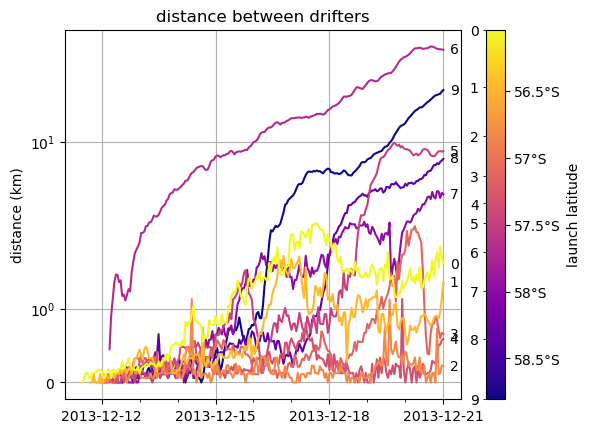

In [13]:
# ANSWER
# students may deviate from the plot below, as long as they show the time evolution of drifter separation in a clear manner
# to find the relation with launching latitude, they could also simply label the lines or print the distance values at t=10days
maxtime = np.datetime64("2013-12-21") # xlim

# plotting
ax = plt.subplot()
norm = mcolors.Normalize(vmin=-58.805,vmax=-56.043)
cmap = matplotlib.colormaps['plasma']
lats0 = list(reversed([d['lat0'] for d in dists]))
lines = []
for dist in dists:
    tmax = np.argmax(dist['time'] > maxtime)
    lines.append(ax.plot(dist['time'][:tmax], dist['distance'][:tmax]/1000,
                          c=cmap(norm(dist['lat0']))))
    x=lines[-1][0].get_xdata()[-1] + np.timedelta64(4,'h')
    y=lines[-1][0].get_ydata()[-1]
    ax.text(x, y, str(lats0.index(dist['lat0'])), va='center', ha='left')

# formatting
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.set_title(f"distance between drifters")
ax.set_ylabel('distance (km)')
ax.set_yscale('symlog')
ax.grid()

# colorbar
cb = ax.figure.colorbar(
    matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax, orientation='vertical', label='launch latitude')
cb.ax.yaxis.set_major_formatter(cartopy.mpl.ticker.LatitudeFormatter())
cb.ax.set_yticks(lats0, labels=range(len(dists)), minor=True)
cb.ax.yaxis.set_tick_params(which='minor', left=True, right=False, labelleft=True, labelright=False)

It is time to compare your results. Create a plot of the pairwise dispersion, $D^2$, similar to figure 5a in the [article](https://doi.org/10.1002/2015JC010972). You do not need to fit the data and calculate the slopes, but do check if the impact of the outlier drifter pair on the mean is similar.

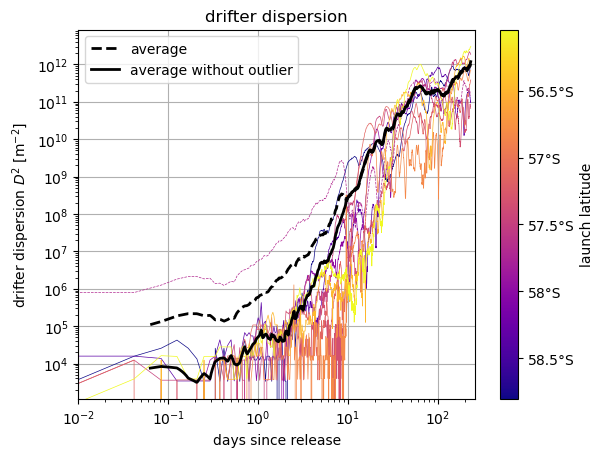

In [14]:
# ANSWER
# the different colours depending on launching latitude again not needed
# values are interpolated to specific time stamps before taking the ensemble mean, any other method is fine here
# results actually deviate slightly from paper, maybe worth looking into

# plotting drifter data
ax = plt.subplot()
norm = mcolors.Normalize(vmin=-58.805,vmax=-56.043)
cmap = matplotlib.colormaps['plasma']
lats0 = list(reversed([d['lat0'] for d in dists]))
lines = []
disps_m = []
days_m = 10**np.linspace(-1.2,2.365,500) # time points to evaluate mean
for i,dist in enumerate(dists):
    if dist['distance'][0] > 200:
        ls = '--'
        ioutlier = i
    else:
        ls = '-'
    time = dist['time'] - dist['time'][0]
    days = time.astype('timedelta64[s]').astype('int')/86400
    lines.append(ax.plot(days, dist['distance']**2,
                          c=cmap(norm(dist['lat0'])), lw=0.5, ls=ls))
    disps_m.append(np.interp(days_m,days,dist['distance']**2, right=np.nan))
    # x=lines[-1][0].get_xdata()[-1] + 1/6
    # y=lines[-1][0].get_ydata()[-1]
    # ax.text(x, y, str(lats0.index(dist['lat0'])), va='center', ha='left')

# plot ensemble mean
disp_m = np.nanmean(disps_m, axis=0)
disps_m.pop(ioutlier)
disp_m_corr = np.nanmean(disps_m, axis=0)
ax.plot(days_m, disp_m, 'k--', lw=2, label='average')
ax.plot(days_m, disp_m_corr, 'k-', lw=2, label='average without outlier')


# formatting
ax.legend(loc='upper left')
ax.set_title(f"drifter dispersion")
ax.set_xlabel('days since release')
ax.set_ylabel(r'drifter dispersion $D^2$ [m$^{-2}$]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([10**(-2),2.6*10**2])
ax.grid()

# colorbar
cb = ax.figure.colorbar(
    matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax, orientation='vertical', label='launch latitude')
cb.ax.yaxis.set_major_formatter(cartopy.mpl.ticker.LatitudeFormatter())
# cb.ax.set_yticks(lats0, labels=range(len(dists)), minor=True)
# cb.ax.yaxis.set_tick_params(which='minor', left=True, right=False, labelleft=True, labelright=False)